In [1]:
import pandas as pd
import scanpy as sc
import h5py
import CococoNet_reader
import numpy as np
import anndata
import pickle
import tqdm
import Go_annotations
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  
sc.set_figure_params(facecolor = 'white', figsize = (10,8))

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [3]:
single_cell_h5py = h5py.File('/data/passala/Data_from_CoCoCoNet/single_cell_data/Ara_data.hdf5','r')
list(single_cell_h5py.keys())
col_data = single_cell_h5py['coldata']
row_data = single_cell_h5py['rowdata']
embedding_data = single_cell_h5py['embedding']
normalized_counts = single_cell_h5py['normalized_counts']

row_data_decoded = []

for gene_name in row_data:
    row_data_decoded.append(gene_name[0].decode())

cell_type_number =[]
study_number = []
study_id = []
batch_cluster = []
meta_cluster = []
umap_coordinates = []

for cell_identity in col_data:
    cell_type_number.append(cell_identity[0])  
    study_number.append(cell_identity[1])
    study_id.append(cell_identity[2])
    batch_cluster.append(cell_identity[3])
    meta_cluster.append(cell_identity[4])

barcode_for_each_cell = [] 
for barcode in embedding_data:
    barcode_for_each_cell.append(barcode[2])
    current_umap_coordinates =[barcode[1],barcode[0]]
    umap_coordinates.append(current_umap_coordinates)
umap_coordinates = np.array(umap_coordinates)


In [4]:
obs_arabidop = pd.DataFrame(index = barcode_for_each_cell, data = list(zip(cell_type_number,study_number,batch_cluster, meta_cluster)), columns = ['Cell Type','Study Number','Batch Cluster','Meta Cluster'] )

vars_arabidop = pd.DataFrame(index = row_data_decoded)
single_cell_arabidopsis_root_4_datasets = anndata.AnnData(X = normalized_counts[:],obs = obs_arabidop, var = vars_arabidop)
single_cell_arabidopsis_root_4_datasets.obsm['X_umap'] = umap_coordinates
umap_df = pd.DataFrame(data = single_cell_arabidopsis_root_4_datasets.obsm['X_umap'], columns = ['Axis 1','Axis 2'], index = barcode_for_each_cell)
bad_values = umap_df.sort_values(by = 'Axis 1', ascending = False).head(6).index
single_cell_arabidopsis_root_4_datasets.obs.loc[bad_values]
good_obs = single_cell_arabidopsis_root_4_datasets.obs.loc[~single_cell_arabidopsis_root_4_datasets.obs.index.isin(bad_values)]
single_cell_arabidopsis_root_4_datasets  = single_cell_arabidopsis_root_4_datasets[good_obs.index,:]

/tmp/ipykernel_28295/2112258600.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  single_cell_arabidopsis_root_4_datasets = anndata.AnnData(X = normalized_counts[:],obs = obs_arabidop, var = vars_arabidop)


In [5]:
single_cell_arabidopsis_root_4_datasets.obs['Meta Cluster String'] =single_cell_arabidopsis_root_4_datasets.obs['Meta Cluster'].astype(str)

/tmp/ipykernel_28295/1255668264.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  single_cell_arabidopsis_root_4_datasets.obs['Meta Cluster String'] =single_cell_arabidopsis_root_4_datasets.obs['Meta Cluster'].astype(str)


In [6]:
sc.pp.filter_cells(single_cell_arabidopsis_root_4_datasets, min_genes=300)
sc.pp.filter_genes(single_cell_arabidopsis_root_4_datasets, min_cells=10)

filtered out 1196 genes that are detected in less than 10 cells


In [7]:
sc.pp.highly_variable_genes(single_cell_arabidopsis_root_4_datasets, min_mean=0.125, max_mean=4, min_disp=0.5)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


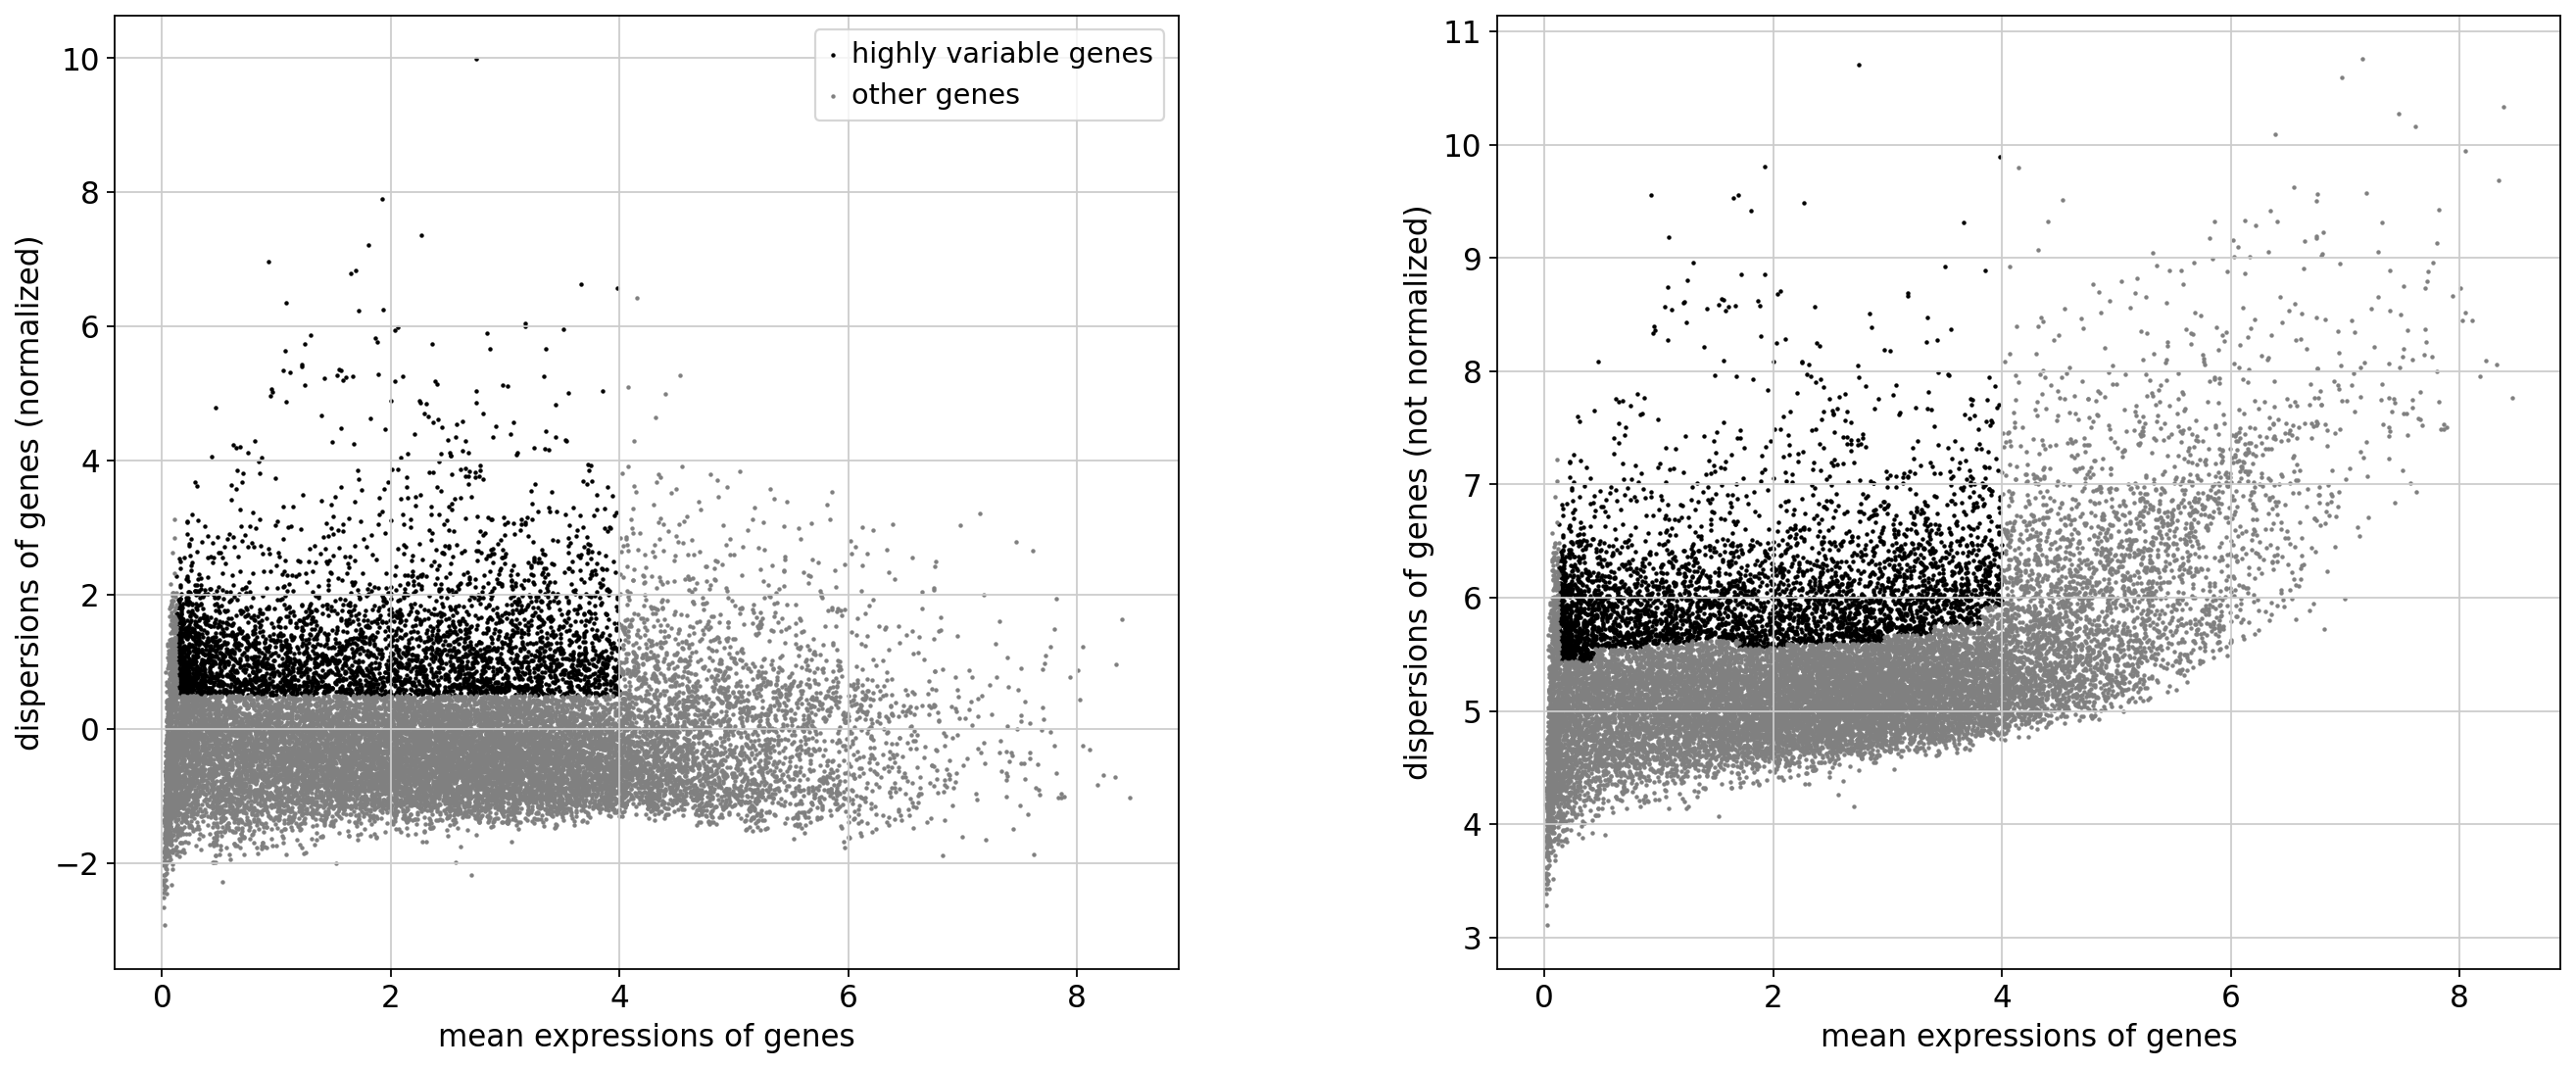

In [8]:
sc.pl.highly_variable_genes(single_cell_arabidopsis_root_4_datasets, )


In [9]:
#sc.pl.highly_variable_genes(single_cell_arabidopsis_root_4_datasets)


In [10]:
sc.tl.pca(single_cell_arabidopsis_root_4_datasets, svd_solver='arpack', random_state=303)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


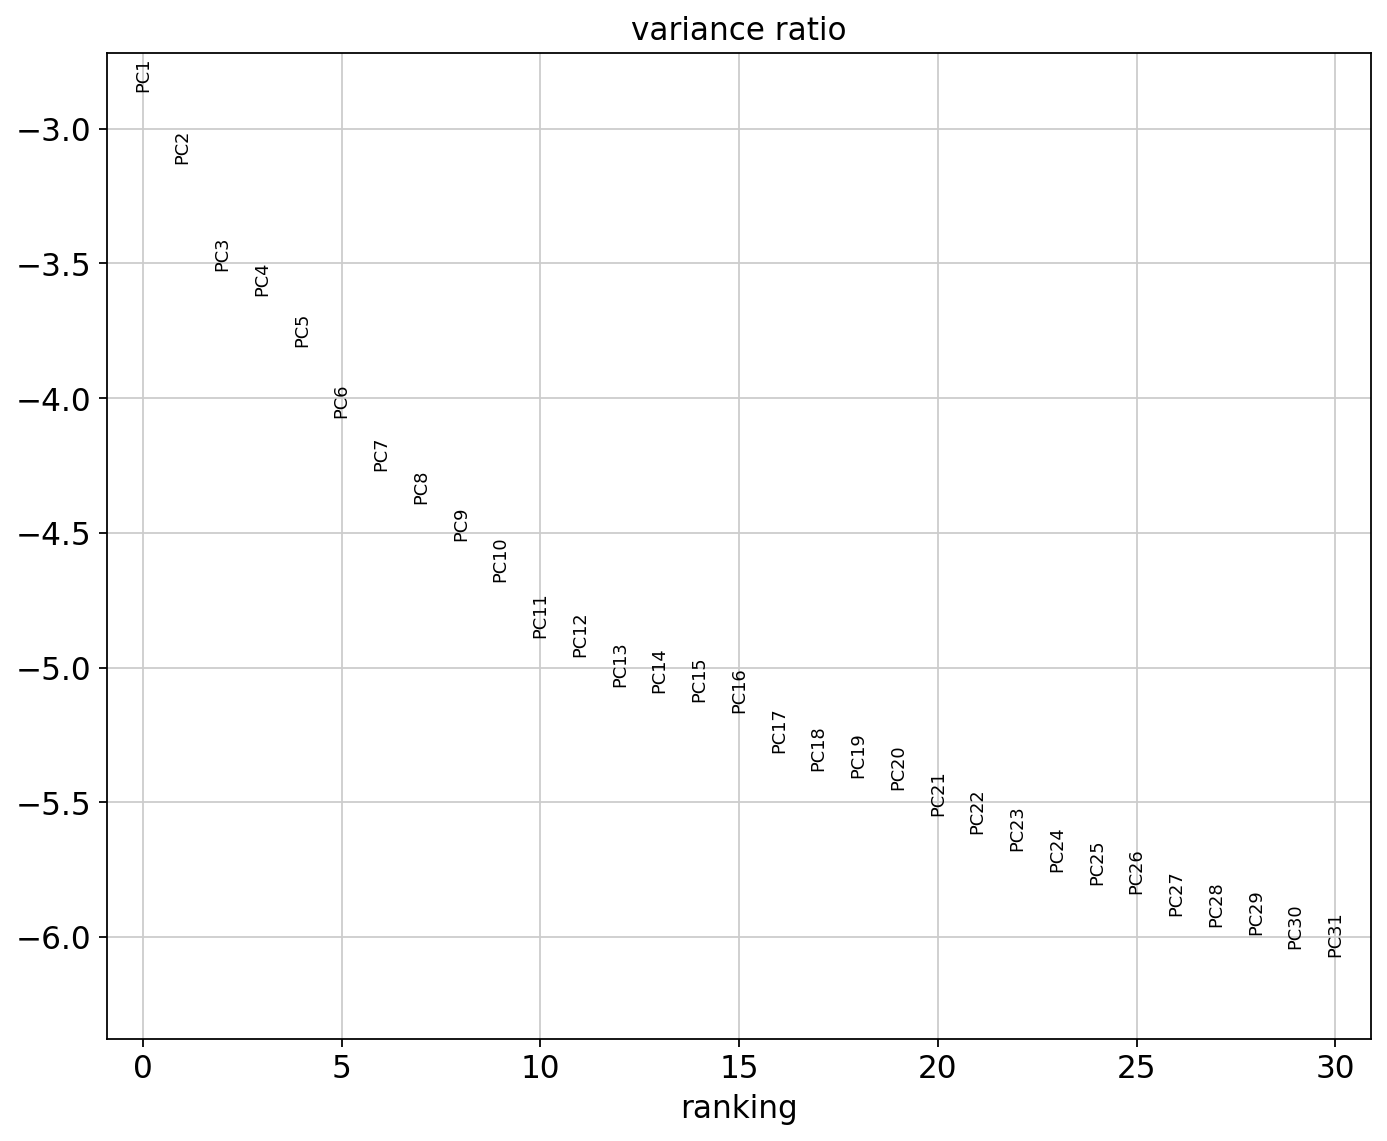

In [11]:
sc.pl.pca_variance_ratio(single_cell_arabidopsis_root_4_datasets, log=True)


In [12]:
sc.pp.neighbors(single_cell_arabidopsis_root_4_datasets, n_neighbors=12, n_pcs=50)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)


In [13]:
sc.tl.umap(single_cell_arabidopsis_root_4_datasets, random_state = 233)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


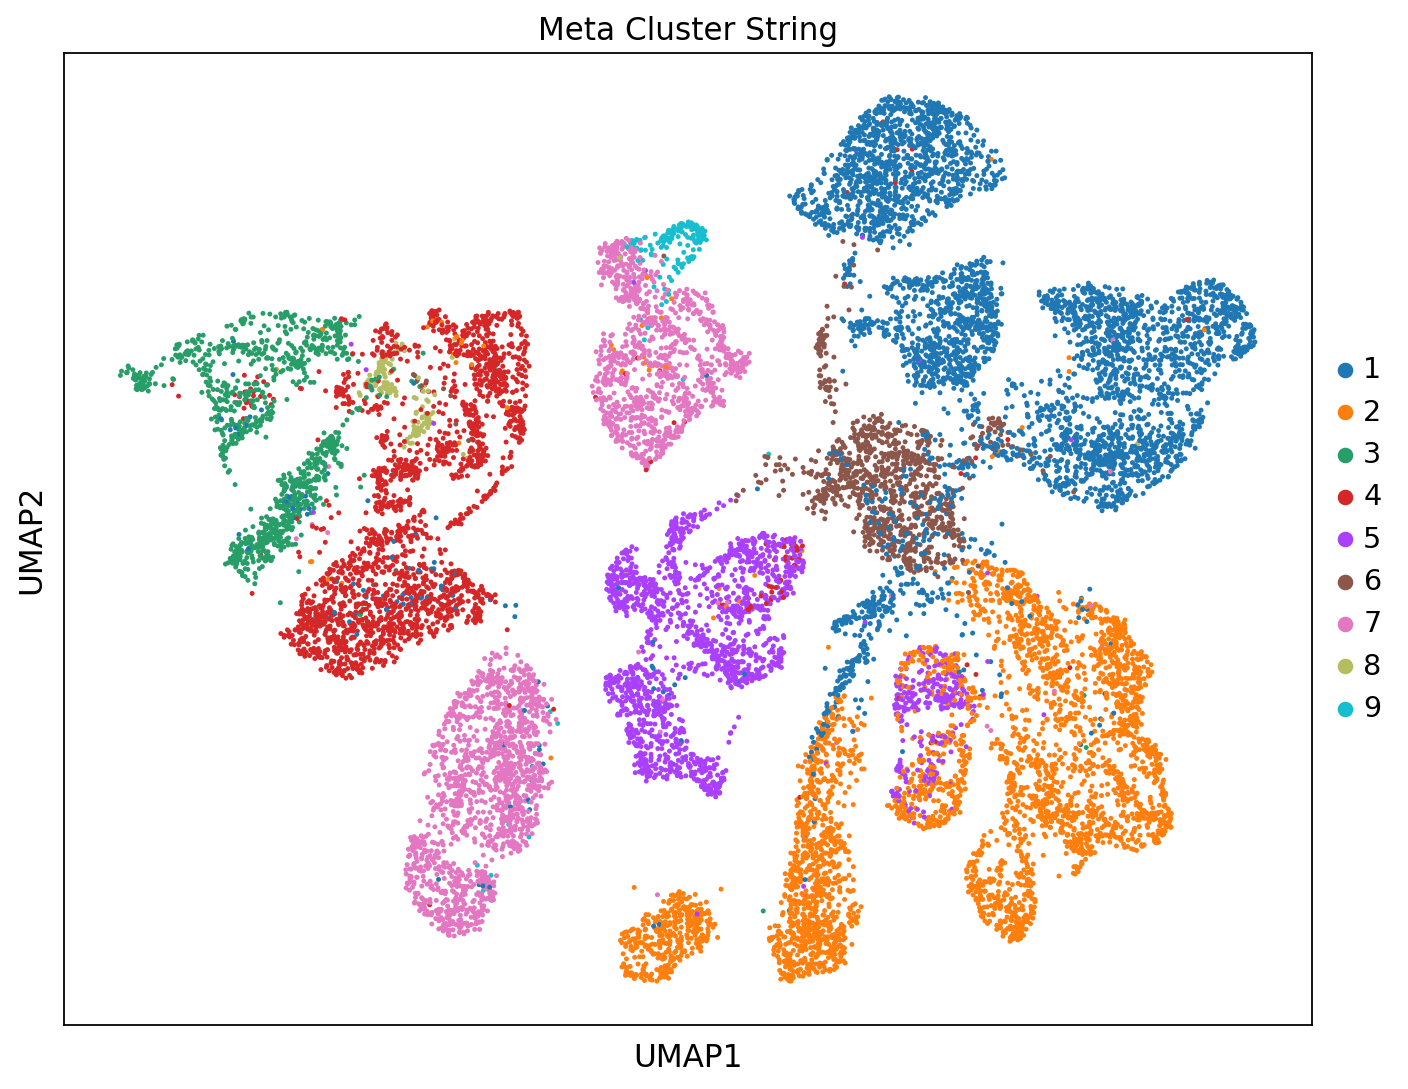

In [14]:
sc.pl.umap(single_cell_arabidopsis_root_4_datasets,color = 'Meta Cluster String', s = 20)

In [15]:
sc.tl.leiden(single_cell_arabidopsis_root_4_datasets,resolution = 15, random_state = 325)

running Leiden clustering
    finished: found 193 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [16]:
single_cell_arabidopsis_root_4_datasets.obs['leiden'].value_counts().tail(20)

173    41
174    40
175    39
176    38
177    35
178    33
179    32
180    32
181    31
182    30
183    27
184    26
185    26
186    24
187    23
188    22
189    19
190    17
191    16
192     5
Name: leiden, dtype: int64

In [17]:
single_cell_arabidopsis_root_4_datasets

AnnData object with n_obs × n_vars = 16635 × 21075
    obs: 'Cell Type', 'Study Number', 'Batch Cluster', 'Meta Cluster', 'Meta Cluster String', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'Meta Cluster String_colors', 'leiden'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [18]:
single_cell_arabidopsis_root_4_datasets = single_cell_arabidopsis_root_4_datasets[:,single_cell_arabidopsis_root_4_datasets.var['means']>0]

In [19]:
psuedobulk_df = pd.DataFrame(index = single_cell_arabidopsis_root_4_datasets.var_names)
all_samples = list(single_cell_arabidopsis_root_4_datasets.obs.leiden.unique()) # Generate list of all combinations of the above ## Make a base dataframe index we will add stuff on to later
psuedobulk_df

""
AT1G01010
AT1G01020
AT1G01030
AT1G01040
AT1G01050
...
ATCG01090
ATCG01100
ATCG01110
ATCG01120


In [20]:
len(all_samples)

193

In [21]:
for batch_type in all_samples:

    ## Read in the Names so our code is easy to understand
    current_cluster = batch_type

    ## Calculate the Psuedobulked mean
    cells_matching_batch_and_cluster = single_cell_arabidopsis_root_4_datasets[single_cell_arabidopsis_root_4_datasets.obs['leiden'] == current_cluster ]
    mean_of_genes = cells_matching_batch_and_cluster.X.mean(axis = 0).tolist()


    name_of_combo = current_cluster
    psuedobulk_df[name_of_combo] = mean_of_genes

/tmp/ipykernel_28295/1629521586.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psuedobulk_df[name_of_combo] = mean_of_genes
/tmp/ipykernel_28295/1629521586.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psuedobulk_df[name_of_combo] = mean_of_genes
/tmp/ipykernel_28295/1629521586.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

In [22]:
psuedobulk_df

,70,6,46,149,26,47,120,11,103,98,...,121,114,7,9,171,59,167,183,157,78
AT1G01010,0.932953,0.037679,0.539014,0.217292,1.320032,0.053026,0.543055,1.196611,0.595964,0.284224,...,4.263611,2.748220,0.201831,2.906942,0.912110,3.010768,0.000000,1.171647,0.089356,2.629014
AT1G01020,0.260394,0.143550,0.781758,1.111135,0.188733,0.354486,0.803221,0.380230,2.363353,0.858340,...,2.051564,1.211645,1.832616,1.730055,3.387345,1.268905,1.232637,0.460981,1.456991,0.898187
AT1G01030,0.000000,0.000000,0.000000,0.000000,0.067597,0.049306,0.000000,0.707618,0.262413,0.188769,...,0.000000,0.046427,0.000000,1.548625,0.000000,2.850949,0.346837,0.760271,0.090749,0.317539
AT1G01040,0.429936,0.138359,0.167072,0.071983,0.295214,0.000000,0.000000,0.885748,0.636084,0.059449,...,0.899907,0.582434,0.030251,0.850240,0.143939,1.098565,0.270495,0.465818,0.091213,0.462420
AT1G01050,2.941705,2.594030,4.710402,5.045591,3.030305,3.121704,2.178175,1.803417,5.230929,4.067708,...,5.139423,3.645594,4.913805,3.537553,2.930433,4.455028,5.650528,4.518431,5.214279,2.827647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.060795,0.000000,0.076704,0.000000,0.112406,0.096840,0.000000,0.000000,0.424574,0.135617,...,0.047060,0.102939,0.000000,0.022443,0.000000,0.032524,0.000000,0.000000,0.000000,0.075513
ATCG01100,0.055473,0.000000,0.000000,0.000000,0.040035,0.000000,0.000000,0.036259,0.022018,0.212776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149344,0.000000,0.000000
ATCG01110,0.000000,0.000000,0.000000,0.000000,0.038638,0.000000,0.000000,0.000000,0.036504,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ATCG01120,0.000000,0.000000,0.077879,0.130508,0.034112,0.000000,0.178414,0.035096,0.117405,0.067022,...,0.000000,0.054588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
exp_data = psuedobulk_df

In [24]:
import numpy as np
import scipy.stats as sci

rank_test_py_exp = sci.rankdata(exp_data, method = 'average', axis = 1)                #Row ranks
rank_test_py_exp = rank_test_py_exp - rank_test_py_exp.mean(axis = 1)[1]               #Center each gene, subtract mean rank
rank_test_py_exp_2 = np.square(rank_test_py_exp)                                       #Square
rank_test_py_exp = rank_test_py_exp /np.sqrt(rank_test_py_exp_2.sum(axis = 1))[:,None] #divide by sqrt(rowSums)
cr_python = np.dot(rank_test_py_exp, rank_test_py_exp.T)                               # Get correlations

In [25]:
cr_python

array([[ 1.        ,  0.30777577,  0.29139459, ...,  0.16106326,
         0.10447514,  0.23253174],
       [ 0.30777577,  1.        ,  0.37523188, ..., -0.10906657,
        -0.13430138,  0.27646156],
       [ 0.29139459,  0.37523188,  1.        , ..., -0.04186592,
        -0.08484954,  0.17650928],
       ...,
       [ 0.16106326, -0.10906657, -0.04186592, ...,  1.        ,
         0.58286593,  0.41910364],
       [ 0.10447514, -0.13430138, -0.08484954, ...,  0.58286593,
         1.        ,  0.48029141],
       [ 0.23253174,  0.27646156,  0.17650928, ...,  0.41910364,
         0.48029141,  1.        ]])

In [26]:
corr_results = pd.DataFrame(columns = psuedobulk_df.index, index = psuedobulk_df.index, data = cr_python)
corr_results

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01010,1.000000,0.307776,0.291395,0.579701,-0.021515,0.059673,0.381870,0.219930,0.120631,-0.163891,...,0.315084,0.022321,-0.001901,0.177482,0.154197,0.166636,0.238438,0.161063,0.104475,0.232532
AT1G01020,0.307776,1.000000,0.375232,0.484150,0.685491,-0.074806,0.374679,0.466042,0.644312,0.564354,...,0.475233,0.210756,0.068284,-0.042057,0.064806,0.091470,-0.188531,-0.109067,-0.134301,0.276462
AT1G01030,0.291395,0.375232,1.000000,0.506674,0.194249,0.340827,-0.077021,0.229063,0.487539,0.287704,...,0.280047,0.159620,0.019729,0.037871,0.030255,0.140847,-0.042008,-0.041866,-0.084850,0.176509
AT1G01040,0.579701,0.484150,0.506674,1.000000,0.328518,0.288125,0.475316,0.440836,0.563377,0.246761,...,0.479542,0.102040,0.188603,0.143041,0.135150,0.219629,0.130431,0.065242,0.046850,0.423586
AT1G01050,-0.021515,0.685491,0.194249,0.328518,1.000000,-0.204180,0.380598,0.418844,0.786279,0.756709,...,0.385172,0.100116,0.181295,-0.104337,-0.070316,0.006536,-0.306094,-0.228196,-0.290470,0.256331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.166636,0.091470,0.140847,0.219629,0.006536,0.349639,-0.033254,0.313798,0.210875,0.179541,...,0.621264,0.368465,0.443338,0.434744,0.391830,1.000000,0.461787,0.478142,0.479877,0.614700
ATCG01100,0.238438,-0.188531,-0.042008,0.130431,-0.306094,0.343193,-0.114384,0.022096,-0.144212,-0.218429,...,0.327588,0.235874,0.242922,0.523429,0.321805,0.461787,1.000000,0.593406,0.612890,0.452774
ATCG01110,0.161063,-0.109067,-0.041866,0.065242,-0.228196,0.274757,-0.112679,0.068888,-0.118615,-0.164747,...,0.379863,0.238830,0.294468,0.486987,0.465221,0.478142,0.593406,1.000000,0.582866,0.419104
ATCG01120,0.104475,-0.134301,-0.084850,0.046850,-0.290470,0.348106,-0.082337,0.105788,-0.123145,-0.107077,...,0.353467,0.320063,0.325840,0.490897,0.425011,0.479877,0.612890,0.582866,1.000000,0.480291


In [27]:
arabi_net = CococoNet_reader.read_cococonet('arabidopsis')
arabi_net

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130,ATCG01180,ATCG01210,ATCG01310
AT1G01020,1.000000,0.676041,0.885107,0.916603,0.167027,0.625596,0.801175,0.866369,0.954286,0.715750,...,0.111731,0.193853,0.261697,0.299060,0.321617,0.287853,0.559907,0.017205,0.011806,0.091015
AT1G01030,0.676041,1.000000,0.707718,0.515532,0.420354,0.292083,0.687003,0.626281,0.483536,0.570675,...,0.245167,0.215414,0.255414,0.306986,0.308402,0.270118,0.463394,0.083490,0.059014,0.108780
AT1G01040,0.885107,0.707718,1.000000,0.836387,0.545101,0.701558,0.656258,0.857046,0.657204,0.650843,...,0.155183,0.230038,0.149740,0.334558,0.287951,0.186425,0.219380,0.032348,0.018332,0.057761
AT1G01050,0.916603,0.515532,0.836387,1.000000,0.562112,0.726964,0.837948,0.928252,0.952045,0.640223,...,0.089440,0.177388,0.164935,0.236661,0.251851,0.213062,0.412583,0.046082,0.029016,0.086736
AT1G01060,0.167027,0.420354,0.545101,0.562112,1.000000,0.327202,0.242215,0.304953,0.217415,0.077569,...,0.082518,0.125455,0.103488,0.187982,0.195059,0.125488,0.212731,0.061676,0.057518,0.044208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01120,0.287853,0.270118,0.186425,0.213062,0.125488,0.083681,0.364707,0.333718,0.237716,0.149145,...,0.858389,0.905572,0.926062,0.941864,0.954421,1.000000,0.969018,0.450607,0.357960,0.410586
ATCG01130,0.559907,0.463394,0.219380,0.412583,0.212731,0.077222,0.625678,0.496059,0.428496,0.226147,...,0.881835,0.936241,0.946935,0.958553,0.960399,0.969018,1.000000,0.467233,0.412343,0.483002
ATCG01180,0.017205,0.083490,0.032348,0.046082,0.061676,0.022381,0.090228,0.069825,0.028903,0.015799,...,0.751869,0.781811,0.740045,0.745181,0.676666,0.450607,0.467233,1.000000,0.999090,0.579657
ATCG01210,0.011806,0.059014,0.018332,0.029016,0.057518,0.026014,0.062831,0.043944,0.015468,0.018706,...,0.687306,0.710940,0.676507,0.687223,0.567304,0.357960,0.412343,0.999090,1.000000,0.511263


In [28]:
arabi_net_col_trimmed = arabi_net[arabi_net.columns.intersection(corr_results.index)]
arabi_net_both_trimmed = arabi_net_col_trimmed.loc[arabi_net_col_trimmed.index.isin(corr_results.index)]

In [29]:
arabi_net_both_trimmed

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01020,1.000000,0.676041,0.885107,0.916603,0.167027,0.625596,0.801175,0.866369,0.954286,0.715750,...,0.591231,0.233666,0.266479,0.111731,0.193853,0.261697,0.299060,0.321617,0.287853,0.559907
AT1G01030,0.676041,1.000000,0.707718,0.515532,0.420354,0.292083,0.687003,0.626281,0.483536,0.570675,...,0.554928,0.230595,0.365060,0.245167,0.215414,0.255414,0.306986,0.308402,0.270118,0.463394
AT1G01040,0.885107,0.707718,1.000000,0.836387,0.545101,0.701558,0.656258,0.857046,0.657204,0.650843,...,0.238919,0.101229,0.302657,0.155183,0.230038,0.149740,0.334558,0.287951,0.186425,0.219380
AT1G01050,0.916603,0.515532,0.836387,1.000000,0.562112,0.726964,0.837948,0.928252,0.952045,0.640223,...,0.358282,0.236799,0.173902,0.089440,0.177388,0.164935,0.236661,0.251851,0.213062,0.412583
AT1G01060,0.167027,0.420354,0.545101,0.562112,1.000000,0.327202,0.242215,0.304953,0.217415,0.077569,...,0.153835,0.123996,0.097794,0.082518,0.125455,0.103488,0.187982,0.195059,0.125488,0.212731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.261697,0.255414,0.149740,0.164935,0.103488,0.055508,0.371074,0.341312,0.084160,0.127037,...,0.737622,0.924768,0.986342,0.970733,0.987386,1.000000,0.991884,0.972589,0.926062,0.946935
ATCG01100,0.299060,0.306986,0.334558,0.236661,0.187982,0.085623,0.439777,0.367577,0.094098,0.126890,...,0.799907,0.956868,0.998698,0.992374,0.997454,0.991884,1.000000,0.996139,0.941864,0.958553
ATCG01110,0.321617,0.308402,0.287951,0.251851,0.195059,0.060340,0.357794,0.387466,0.158726,0.163126,...,0.669740,0.925114,0.987717,0.958313,0.985484,0.972589,0.996139,1.000000,0.954421,0.960399
ATCG01120,0.287853,0.270118,0.186425,0.213062,0.125488,0.083681,0.364707,0.333718,0.237716,0.149145,...,0.780961,0.871263,0.905485,0.858389,0.905572,0.926062,0.941864,0.954421,1.000000,0.969018


In [30]:
corr_results

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01010,1.000000,0.307776,0.291395,0.579701,-0.021515,0.059673,0.381870,0.219930,0.120631,-0.163891,...,0.315084,0.022321,-0.001901,0.177482,0.154197,0.166636,0.238438,0.161063,0.104475,0.232532
AT1G01020,0.307776,1.000000,0.375232,0.484150,0.685491,-0.074806,0.374679,0.466042,0.644312,0.564354,...,0.475233,0.210756,0.068284,-0.042057,0.064806,0.091470,-0.188531,-0.109067,-0.134301,0.276462
AT1G01030,0.291395,0.375232,1.000000,0.506674,0.194249,0.340827,-0.077021,0.229063,0.487539,0.287704,...,0.280047,0.159620,0.019729,0.037871,0.030255,0.140847,-0.042008,-0.041866,-0.084850,0.176509
AT1G01040,0.579701,0.484150,0.506674,1.000000,0.328518,0.288125,0.475316,0.440836,0.563377,0.246761,...,0.479542,0.102040,0.188603,0.143041,0.135150,0.219629,0.130431,0.065242,0.046850,0.423586
AT1G01050,-0.021515,0.685491,0.194249,0.328518,1.000000,-0.204180,0.380598,0.418844,0.786279,0.756709,...,0.385172,0.100116,0.181295,-0.104337,-0.070316,0.006536,-0.306094,-0.228196,-0.290470,0.256331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.166636,0.091470,0.140847,0.219629,0.006536,0.349639,-0.033254,0.313798,0.210875,0.179541,...,0.621264,0.368465,0.443338,0.434744,0.391830,1.000000,0.461787,0.478142,0.479877,0.614700
ATCG01100,0.238438,-0.188531,-0.042008,0.130431,-0.306094,0.343193,-0.114384,0.022096,-0.144212,-0.218429,...,0.327588,0.235874,0.242922,0.523429,0.321805,0.461787,1.000000,0.593406,0.612890,0.452774
ATCG01110,0.161063,-0.109067,-0.041866,0.065242,-0.228196,0.274757,-0.112679,0.068888,-0.118615,-0.164747,...,0.379863,0.238830,0.294468,0.486987,0.465221,0.478142,0.593406,1.000000,0.582866,0.419104
ATCG01120,0.104475,-0.134301,-0.084850,0.046850,-0.290470,0.348106,-0.082337,0.105788,-0.123145,-0.107077,...,0.353467,0.320063,0.325840,0.490897,0.425011,0.479877,0.612890,0.582866,1.000000,0.480291


In [31]:
corr_results_col_trimmed = corr_results[corr_results.columns.intersection(arabi_net_both_trimmed.index)]
corr_results_both_trimmed = corr_results_col_trimmed.loc[corr_results_col_trimmed.index.isin(arabi_net_both_trimmed.index)]

In [32]:
corr_results_both_trimmed

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01020,1.000000,0.375232,0.484150,0.685491,-0.074806,0.374679,0.466042,0.644312,0.564354,0.365965,...,0.475233,0.210756,0.068284,-0.042057,0.064806,0.091470,-0.188531,-0.109067,-0.134301,0.276462
AT1G01030,0.375232,1.000000,0.506674,0.194249,0.340827,-0.077021,0.229063,0.487539,0.287704,0.750036,...,0.280047,0.159620,0.019729,0.037871,0.030255,0.140847,-0.042008,-0.041866,-0.084850,0.176509
AT1G01040,0.484150,0.506674,1.000000,0.328518,0.288125,0.475316,0.440836,0.563377,0.246761,0.441603,...,0.479542,0.102040,0.188603,0.143041,0.135150,0.219629,0.130431,0.065242,0.046850,0.423586
AT1G01050,0.685491,0.194249,0.328518,1.000000,-0.204180,0.380598,0.418844,0.786279,0.756709,0.314951,...,0.385172,0.100116,0.181295,-0.104337,-0.070316,0.006536,-0.306094,-0.228196,-0.290470,0.256331
AT1G01060,-0.074806,0.340827,0.288125,-0.204180,1.000000,-0.125772,0.163956,0.152507,0.117939,0.306930,...,0.346657,0.336645,0.228800,0.216361,0.291156,0.349639,0.343193,0.274757,0.348106,0.400362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.091470,0.140847,0.219629,0.006536,0.349639,-0.033254,0.313798,0.210875,0.179541,0.096731,...,0.621264,0.368465,0.443338,0.434744,0.391830,1.000000,0.461787,0.478142,0.479877,0.614700
ATCG01100,-0.188531,-0.042008,0.130431,-0.306094,0.343193,-0.114384,0.022096,-0.144212,-0.218429,-0.145547,...,0.327588,0.235874,0.242922,0.523429,0.321805,0.461787,1.000000,0.593406,0.612890,0.452774
ATCG01110,-0.109067,-0.041866,0.065242,-0.228196,0.274757,-0.112679,0.068888,-0.118615,-0.164747,-0.071517,...,0.379863,0.238830,0.294468,0.486987,0.465221,0.478142,0.593406,1.000000,0.582866,0.419104
ATCG01120,-0.134301,-0.084850,0.046850,-0.290470,0.348106,-0.082337,0.105788,-0.123145,-0.107077,-0.155945,...,0.353467,0.320063,0.325840,0.490897,0.425011,0.479877,0.612890,0.582866,1.000000,0.480291


In [33]:
corr_results.reindex()

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01010,1.000000,0.307776,0.291395,0.579701,-0.021515,0.059673,0.381870,0.219930,0.120631,-0.163891,...,0.315084,0.022321,-0.001901,0.177482,0.154197,0.166636,0.238438,0.161063,0.104475,0.232532
AT1G01020,0.307776,1.000000,0.375232,0.484150,0.685491,-0.074806,0.374679,0.466042,0.644312,0.564354,...,0.475233,0.210756,0.068284,-0.042057,0.064806,0.091470,-0.188531,-0.109067,-0.134301,0.276462
AT1G01030,0.291395,0.375232,1.000000,0.506674,0.194249,0.340827,-0.077021,0.229063,0.487539,0.287704,...,0.280047,0.159620,0.019729,0.037871,0.030255,0.140847,-0.042008,-0.041866,-0.084850,0.176509
AT1G01040,0.579701,0.484150,0.506674,1.000000,0.328518,0.288125,0.475316,0.440836,0.563377,0.246761,...,0.479542,0.102040,0.188603,0.143041,0.135150,0.219629,0.130431,0.065242,0.046850,0.423586
AT1G01050,-0.021515,0.685491,0.194249,0.328518,1.000000,-0.204180,0.380598,0.418844,0.786279,0.756709,...,0.385172,0.100116,0.181295,-0.104337,-0.070316,0.006536,-0.306094,-0.228196,-0.290470,0.256331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.166636,0.091470,0.140847,0.219629,0.006536,0.349639,-0.033254,0.313798,0.210875,0.179541,...,0.621264,0.368465,0.443338,0.434744,0.391830,1.000000,0.461787,0.478142,0.479877,0.614700
ATCG01100,0.238438,-0.188531,-0.042008,0.130431,-0.306094,0.343193,-0.114384,0.022096,-0.144212,-0.218429,...,0.327588,0.235874,0.242922,0.523429,0.321805,0.461787,1.000000,0.593406,0.612890,0.452774
ATCG01110,0.161063,-0.109067,-0.041866,0.065242,-0.228196,0.274757,-0.112679,0.068888,-0.118615,-0.164747,...,0.379863,0.238830,0.294468,0.486987,0.465221,0.478142,0.593406,1.000000,0.582866,0.419104
ATCG01120,0.104475,-0.134301,-0.084850,0.046850,-0.290470,0.348106,-0.082337,0.105788,-0.123145,-0.107077,...,0.353467,0.320063,0.325840,0.490897,0.425011,0.479877,0.612890,0.582866,1.000000,0.480291


In [34]:
corr_results_both_trimmed = corr_results_both_trimmed.clip(lower=0)


In [35]:
corr_results_both_trimmed = corr_results_both_trimmed[arabi_net_both_trimmed.columns]
corr_results_both_trimmed = corr_results_both_trimmed.T
corr_results_both_trimmed = corr_results_both_trimmed[arabi_net_both_trimmed.columns]
corr_results_both_trimmed

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01020,1.000000,0.375232,0.484150,0.685491,0.000000,0.374679,0.466042,0.644312,0.564354,0.365965,...,0.475233,0.210756,0.068284,0.000000,0.064806,0.091470,0.000000,0.000000,0.000000,0.276462
AT1G01030,0.375232,1.000000,0.506674,0.194249,0.340827,0.000000,0.229063,0.487539,0.287704,0.750036,...,0.280047,0.159620,0.019729,0.037871,0.030255,0.140847,0.000000,0.000000,0.000000,0.176509
AT1G01040,0.484150,0.506674,1.000000,0.328518,0.288125,0.475316,0.440836,0.563377,0.246761,0.441603,...,0.479542,0.102040,0.188603,0.143041,0.135150,0.219629,0.130431,0.065242,0.046850,0.423586
AT1G01050,0.685491,0.194249,0.328518,1.000000,0.000000,0.380598,0.418844,0.786279,0.756709,0.314951,...,0.385172,0.100116,0.181295,0.000000,0.000000,0.006536,0.000000,0.000000,0.000000,0.256331
AT1G01060,0.000000,0.340827,0.288125,0.000000,1.000000,0.000000,0.163956,0.152507,0.117939,0.306930,...,0.346657,0.336645,0.228800,0.216361,0.291156,0.349639,0.343193,0.274757,0.348106,0.400362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.091470,0.140847,0.219629,0.006536,0.349639,0.000000,0.313798,0.210875,0.179541,0.096731,...,0.621264,0.368465,0.443338,0.434744,0.391830,1.000000,0.461787,0.478142,0.479877,0.614700
ATCG01100,0.000000,0.000000,0.130431,0.000000,0.343193,0.000000,0.022096,0.000000,0.000000,0.000000,...,0.327588,0.235874,0.242922,0.523429,0.321805,0.461787,1.000000,0.593406,0.612890,0.452774
ATCG01110,0.000000,0.000000,0.065242,0.000000,0.274757,0.000000,0.068888,0.000000,0.000000,0.000000,...,0.379863,0.238830,0.294468,0.486987,0.465221,0.478142,0.593406,1.000000,0.582866,0.419104
ATCG01120,0.000000,0.000000,0.046850,0.000000,0.348106,0.000000,0.105788,0.000000,0.000000,0.000000,...,0.353467,0.320063,0.325840,0.490897,0.425011,0.479877,0.612890,0.582866,1.000000,0.480291


In [36]:
# %%script false --no-raise-error
# sns.clustermap(corr_results_both_trimmed)

In [37]:
# %%script false --no-raise-error
# sns.clustermap(arabi_net_both_trimmed)

In [38]:
arabi_net_both_trimmed

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01020,1.000000,0.676041,0.885107,0.916603,0.167027,0.625596,0.801175,0.866369,0.954286,0.715750,...,0.591231,0.233666,0.266479,0.111731,0.193853,0.261697,0.299060,0.321617,0.287853,0.559907
AT1G01030,0.676041,1.000000,0.707718,0.515532,0.420354,0.292083,0.687003,0.626281,0.483536,0.570675,...,0.554928,0.230595,0.365060,0.245167,0.215414,0.255414,0.306986,0.308402,0.270118,0.463394
AT1G01040,0.885107,0.707718,1.000000,0.836387,0.545101,0.701558,0.656258,0.857046,0.657204,0.650843,...,0.238919,0.101229,0.302657,0.155183,0.230038,0.149740,0.334558,0.287951,0.186425,0.219380
AT1G01050,0.916603,0.515532,0.836387,1.000000,0.562112,0.726964,0.837948,0.928252,0.952045,0.640223,...,0.358282,0.236799,0.173902,0.089440,0.177388,0.164935,0.236661,0.251851,0.213062,0.412583
AT1G01060,0.167027,0.420354,0.545101,0.562112,1.000000,0.327202,0.242215,0.304953,0.217415,0.077569,...,0.153835,0.123996,0.097794,0.082518,0.125455,0.103488,0.187982,0.195059,0.125488,0.212731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.261697,0.255414,0.149740,0.164935,0.103488,0.055508,0.371074,0.341312,0.084160,0.127037,...,0.737622,0.924768,0.986342,0.970733,0.987386,1.000000,0.991884,0.972589,0.926062,0.946935
ATCG01100,0.299060,0.306986,0.334558,0.236661,0.187982,0.085623,0.439777,0.367577,0.094098,0.126890,...,0.799907,0.956868,0.998698,0.992374,0.997454,0.991884,1.000000,0.996139,0.941864,0.958553
ATCG01110,0.321617,0.308402,0.287951,0.251851,0.195059,0.060340,0.357794,0.387466,0.158726,0.163126,...,0.669740,0.925114,0.987717,0.958313,0.985484,0.972589,0.996139,1.000000,0.954421,0.960399
ATCG01120,0.287853,0.270118,0.186425,0.213062,0.125488,0.083681,0.364707,0.333718,0.237716,0.149145,...,0.780961,0.871263,0.905485,0.858389,0.905572,0.926062,0.941864,0.954421,1.000000,0.969018


In [39]:
## Trim cococonets to match


arab_cococonet_1_set_to_zero = arabi_net_both_trimmed.replace(1,0)
corr_results_both_trimmed = corr_results_both_trimmed.replace(1,0)


top_10_arab_genes = np.array(
    [arab_cococonet_1_set_to_zero[c].nlargest(10).index.values for c in arab_cococonet_1_set_to_zero]
)  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
top_10_arab_genes_dataframe = pd.DataFrame(
    data=top_10_arab_genes,
    index=arab_cococonet_1_set_to_zero.index,
    columns=[
        "One",
        "Two",
        "Three",
        "Four",
        "Five",
        "Six",
        "Seven",
        "Eight",
        "Nine",
        "Ten",
    ],
)


tidy_top_10 = top_10_arab_genes_dataframe.melt(ignore_index= False)

zipped_pairs = zip(tuple(tidy_top_10.index.to_list()),tuple(tidy_top_10['value'].to_list()))

binary_masked_cococonet = pd.DataFrame(data = 0, columns = arab_cococonet_1_set_to_zero.columns, index = arab_cococonet_1_set_to_zero.index)
#binary_masked_cococonet.loc[zip(tuple(tidy_top_10.index.to_list()),tuple(tidy_top_10['value'].to_list()))] = 1
#binary_masked_cococonet.sum(axis =0)
for row,column in zipped_pairs:
    binary_masked_cococonet.at[row,column] = 1

binary_masked_cococonet

ranked_columns_cococonet = corr_results_both_trimmed.rank()
dot_product_cococonet = binary_masked_cococonet.dot(ranked_columns_cococonet)
subtract_minimum = dot_product_cococonet-65 # This is 11+10+9+8+7+6+5+4+3+2
subtract_minimum
function_conservations_scores = subtract_minimum/(subtract_minimum.max().max() - subtract_minimum.min().min())
function_conservations_scores

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01020,ATCG01040,ATCG01050,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130
AT1G01020,0.922476,0.839905,0.783250,0.800473,0.531045,0.702695,0.856496,0.829487,0.826709,0.801835,...,0.804703,0.642609,0.549407,0.420471,0.502244,0.601953,0.368862,0.412494,0.397040,0.700464
AT1G01030,0.691940,0.824914,0.726847,0.577992,0.606759,0.551304,0.718776,0.671192,0.649960,0.755425,...,0.748148,0.611548,0.617983,0.612458,0.572475,0.682826,0.561038,0.469373,0.519259,0.682047
AT1G01040,0.597267,0.547531,0.615684,0.487955,0.621524,0.329608,0.516265,0.549694,0.518854,0.437788,...,0.755309,0.950448,0.803956,0.876571,0.903001,0.885263,0.740610,0.794719,0.759119,0.807071
AT1G01050,0.854265,0.474430,0.598935,0.961141,0.277741,0.816222,0.748221,0.827824,0.743238,0.542422,...,0.700543,0.527920,0.639568,0.324735,0.343983,0.356567,0.368862,0.340447,0.355997,0.637168
AT1G01060,0.185536,0.583091,0.462148,0.158569,0.953895,0.247348,0.310610,0.299865,0.338669,0.521474,...,0.450817,0.652407,0.580274,0.737782,0.809981,0.760313,0.800915,0.730149,0.848993,0.545468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01090,0.054727,0.137910,0.228047,0.084023,0.914799,0.125676,0.242512,0.130165,0.134885,0.120830,...,0.648823,0.826893,0.907753,1.008877,1.007151,1.007598,1.007298,1.008698,1.008935,0.887168
ATCG01100,0.068821,0.172905,0.274705,0.106807,0.899713,0.131449,0.316129,0.179453,0.180769,0.151304,...,0.720759,0.841579,0.911941,1.008587,1.006819,1.006877,1.006609,1.008177,1.008451,0.882859
ATCG01110,0.087672,0.163894,0.288715,0.123824,0.919503,0.159274,0.368102,0.209596,0.218707,0.173015,...,0.799941,0.938441,0.959088,1.008330,1.005330,1.008056,1.006841,1.008409,1.008851,0.958799
ATCG01120,0.093820,0.198654,0.325869,0.123408,0.940987,0.178832,0.417085,0.219128,0.241860,0.185602,...,0.815637,0.922665,0.971044,1.008961,1.007635,1.007582,1.008482,1.008398,1.009219,0.874676


In [40]:
#ranked_function_conservation_scores = function_conservations_scores.rank()

In [41]:
# normalized_ranked_function_conservation_scores = ranked_function_conservation_scores/19211
# normalized_ranked_function_conservation_scores

In [42]:
np.diag(function_conservations_scores)[0:100]

array([0.92247585, 0.82491423, 0.61568374, 0.96114058, 0.95389489,
       0.8827903 , 0.98026247, 1.00298352, 1.00781398, 0.87076677,
       0.62208225, 0.41547747, 0.69133464, 0.96834943, 0.77370504,
       0.70996453, 0.75754562, 0.9676075 , 0.72806824, 0.77403128,
       0.99767948, 0.90388542, 0.44514954, 0.88329019, 0.94032435,
       0.77013744, 0.84729063, 0.91916083, 0.89227758, 0.96626571,
       0.63394793, 0.78121382, 0.76945865, 0.99806361, 0.92427017,
       0.84786681, 0.65592179, 0.6094115 , 0.88904149, 0.74334102,
       0.86883038, 0.92340195, 0.7968944 , 0.55274568, 0.57411968,
       0.38169056, 0.44881712, 0.95878323, 0.7749679 , 0.60548084,
       0.90816863, 0.76454137, 0.67224958, 0.66426196, 0.80841805,
       0.63241144, 0.65677422, 0.8296184 , 0.98830797, 0.81509019,
       0.70091137, 0.79206394, 0.66505651, 0.70931995, 0.66246238,
       0.79542106, 0.65011787, 0.87709688, 0.88299025, 0.79513692,
       0.73524552, 0.7694797 , 0.80833386, 0.76438351, 0.96334

In [43]:
np.median(np.diag(function_conservations_scores))

0.8626055018837743

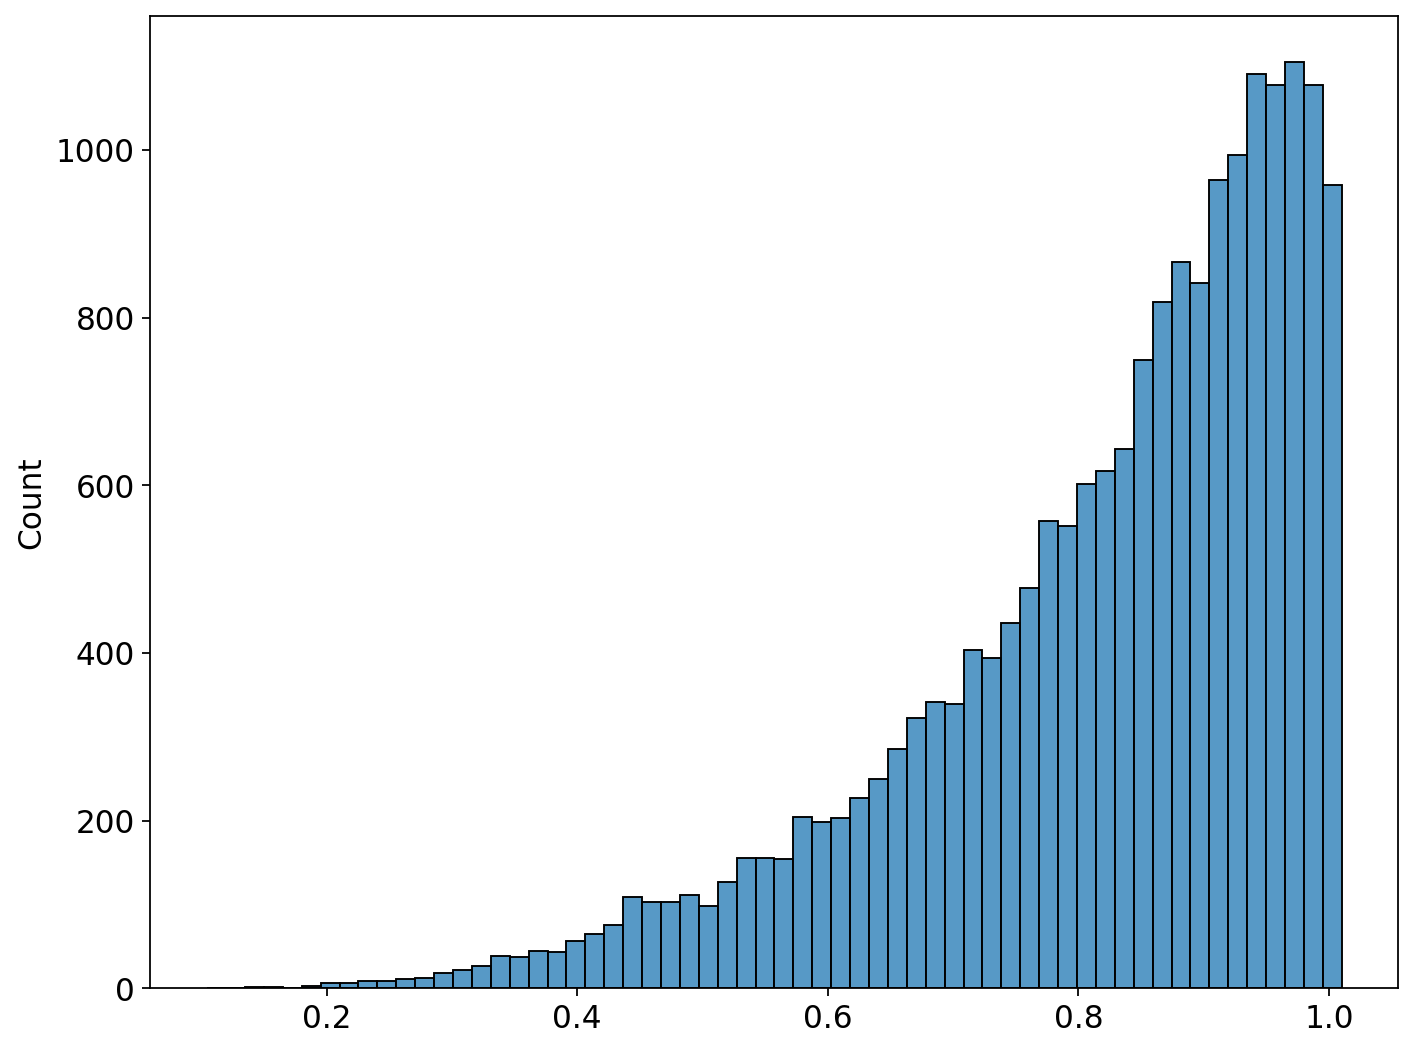

In [44]:
 ax = sns.histplot(np.diag(function_conservations_scores))
 ax.grid(False)